In [1]:
from fastai.vision.all import *
import glob
from tqdm import tqdm
from pathlib import Path
from sklearn.model_selection import train_test_split
import pandas as pd
import shutil

In [2]:
# # prepare the data
# translate_dict = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "ragno": "spider", "scoiattolo": "squirrel"}
# image_paths = glob.glob("downloads/*/*")
# labels = [translate_dict[parent_label(p)] for p in image_paths]
# # split the data into train and test
# train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42, stratify=labels)

# # move to proper directories
# for path, label in tqdm(zip(train_paths, train_labels), total=len(train_paths)):
#     image_id = Path(path).stem
#     os.makedirs(f"data/train/{label}", exist_ok=True)
#     shutil.copy(path, f"data/train/{label}/{image_id}.jpg")
    
# for path, label in tqdm(zip(test_paths, test_labels), total=len(test_paths)):
#     image_id = Path(path).stem
#     os.makedirs(f"data/test/{label}", exist_ok=True)
#     shutil.copy(path, f"data/test/{label}/{image_id}.jpg")
# # count the number of images in each class
# train_counts = {label: len(glob.glob(f"data/train/{label}/*")) for label in translate_dict.values()}
# test_counts = {label: len(glob.glob(f"data/test/{label}/*")) for label in translate_dict.values()}
# print("Train counts:", train_counts)
# print("Test counts:", test_counts)

In [3]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize((224, 224), method='squish')],
    batch_tfms=aug_transforms(size=(224, 224))
)
dls = dblock.dataloaders("data/train", bs=128)

print(f"train : {len(dls.train_ds)}, valid : {len(dls.valid_ds)}")
print(dls.vocab)

train : 16755, valid : 4188
['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


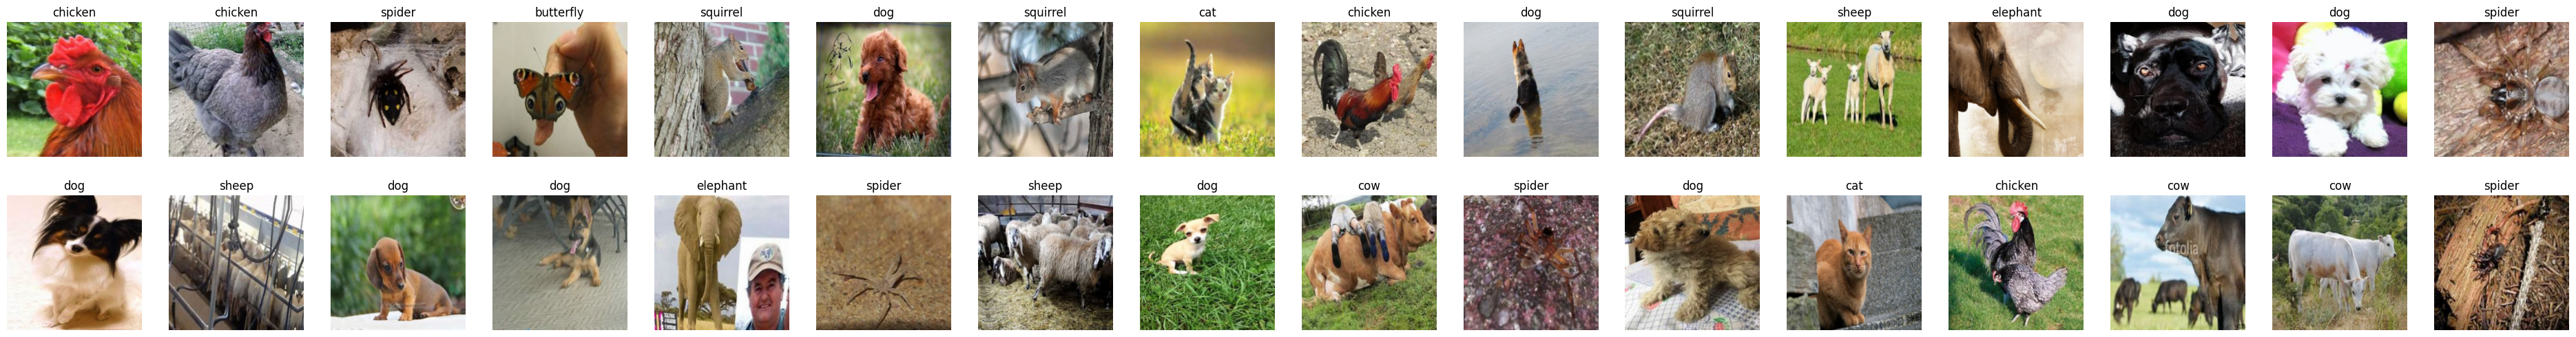

In [4]:
dls.train.show_batch(max_n=32, nrows=2)

SuggestedLRs(valley=0.0010000000474974513)

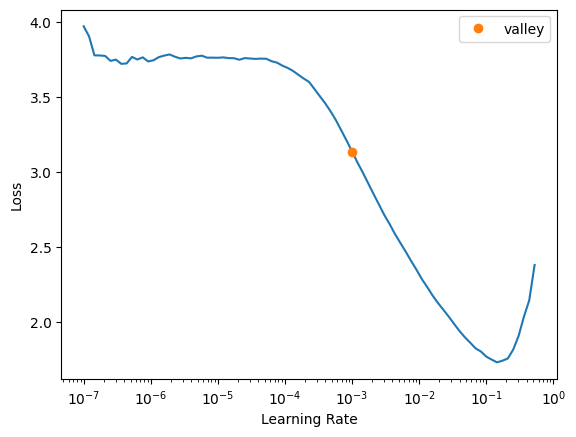

In [5]:
learner = vision_learner(dls, resnet18, metrics=[accuracy, error_rate, Precision(average="macro"), Recall(average="macro"), F1Score(average="macro")])
learner.lr_find()

In [6]:
callback = SaveModelCallback(monitor='valid_loss', fname='best_model', with_opt=True)
learner.fine_tune(epochs=10, freeze_epochs=1, base_lr=0.0010, cbs=callback)

Better model found at epoch 0 with valid_loss value: 0.1761847287416458.


Better model found at epoch 0 with valid_loss value: 0.14124217629432678.
Better model found at epoch 1 with valid_loss value: 0.12868940830230713.
Better model found at epoch 2 with valid_loss value: 0.1209317147731781.
Better model found at epoch 3 with valid_loss value: 0.11546021699905396.
Better model found at epoch 4 with valid_loss value: 0.10482616722583771.
Better model found at epoch 5 with valid_loss value: 0.10072961449623108.
Better model found at epoch 8 with valid_loss value: 0.09874192625284195.


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

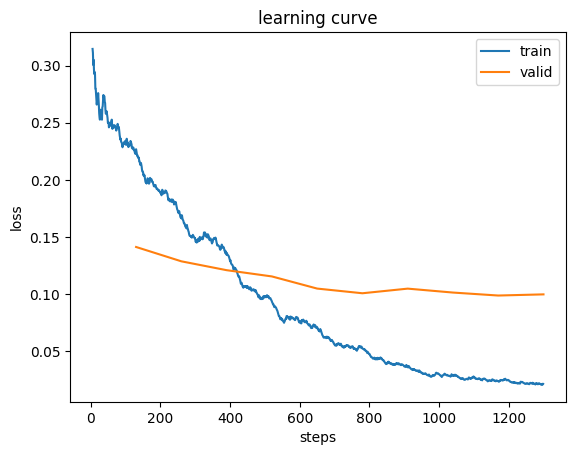

In [7]:
Recorder.plot_loss(learner.recorder)

0.09874192625284195


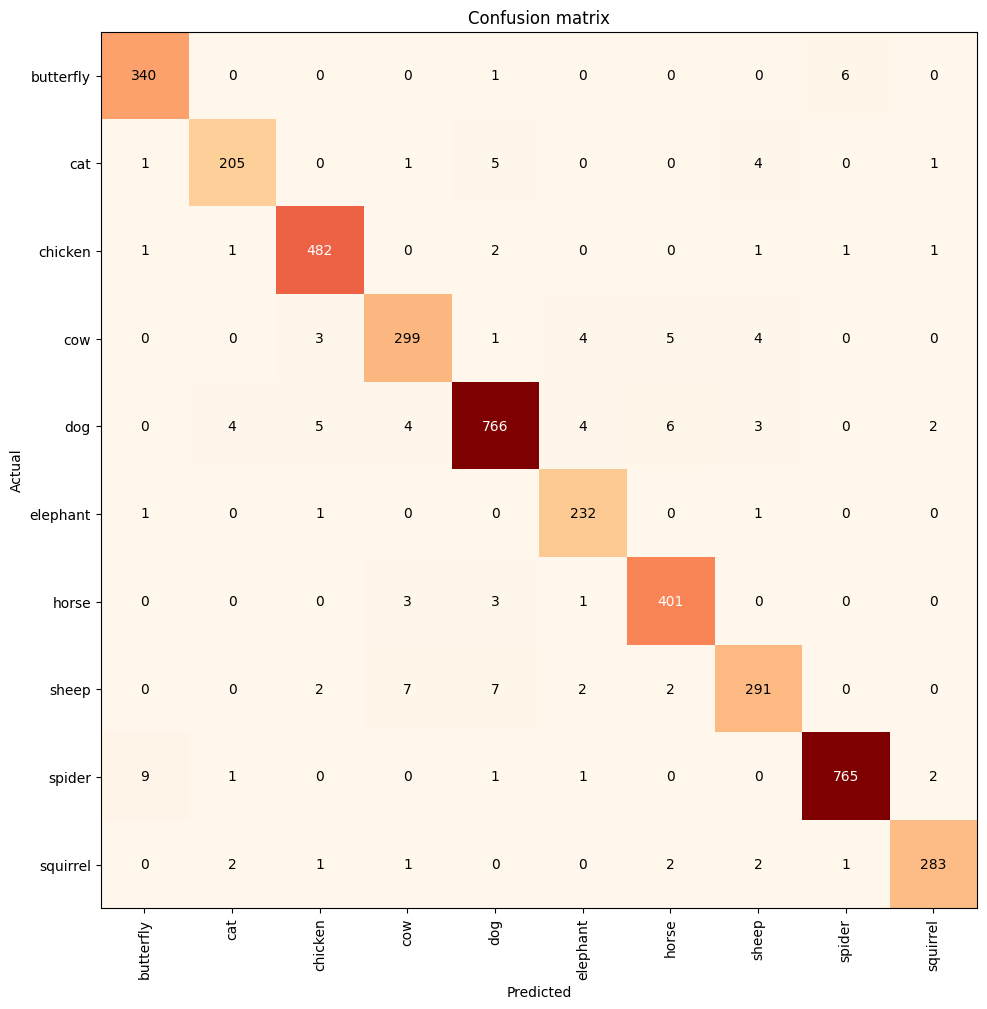

In [8]:
print(callback.best)
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(cmap="OrRd", figsize=(10,10))

In [9]:
interp.print_classification_report()

              precision    recall  f1-score   support

   butterfly       0.97      0.98      0.97       347
         cat       0.96      0.94      0.95       217
     chicken       0.98      0.99      0.98       489
         cow       0.95      0.95      0.95       316
         dog       0.97      0.96      0.97       794
    elephant       0.95      0.99      0.97       235
       horse       0.96      0.98      0.97       408
       sheep       0.95      0.94      0.94       311
      spider       0.99      0.98      0.99       779
    squirrel       0.98      0.97      0.97       292

    accuracy                           0.97      4188
   macro avg       0.97      0.97      0.97      4188
weighted avg       0.97      0.97      0.97      4188



c:\Users\earth\anaconda3\envs\flow\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


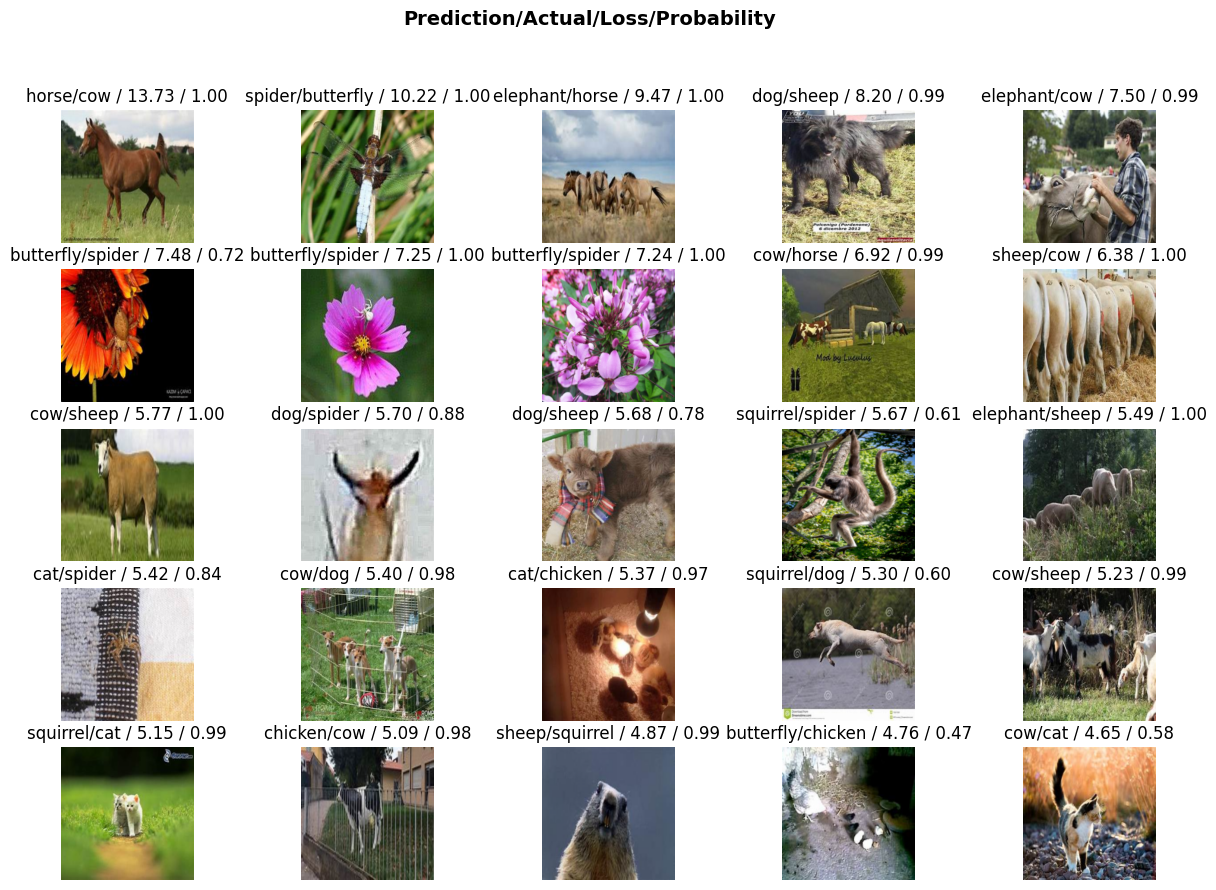

In [11]:
interp.plot_top_losses(25, figsize=(15,10))

In [12]:
learner.load("best_model")
learner.export("models/best_model.pkl")